In [1]:
!ls
!pip3 install idx2numpy

 cse251a_proj1.pdf				   t10k-labels-idx1-ubyte.gz
'Prototype Selection for Nearest Neighbor.ipynb'   train-images-idx3-ubyte
 t10k-images-idx3-ubyte				   train-images-idx3-ubyte.gz
 t10k-images-idx3-ubyte.gz			   train-labels-idx1-ubyte
 t10k-labels-idx1-ubyte				   train-labels-idx1-ubyte.gz


train data shape:  (60000, 28, 28)
train label shape:  (60000,)


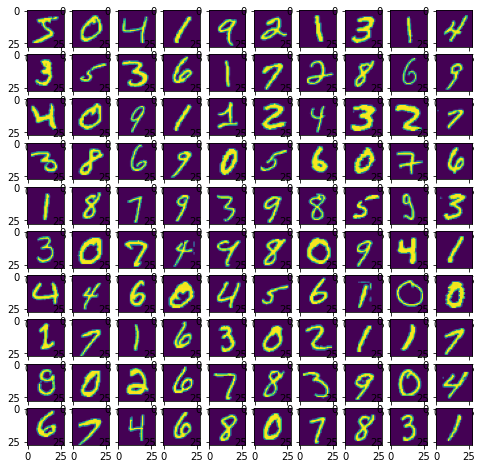

In [2]:
import numpy as np
import pandas as pd
import idx2numpy
import cv2
import matplotlib.pyplot as plt

train_data = idx2numpy.convert_from_file('train-images-idx3-ubyte')
print('train data shape: ', train_data.shape)

train_label = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
print('train label shape: ', train_label.shape)

fig, axes = plt.subplots(10,10, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(train_data[i])

In [3]:
test_data = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
print('test data shape: ', test_data.shape)

test_label = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')
print('test label shape: ', test_label.shape)

test data shape:  (10000, 28, 28)
test label shape:  (10000,)


In [4]:
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

In [5]:
def euclidean_distance(im1, im2):
    return np.sqrt(np.sum(np.power(im1 - im2, 2)))

def manhattan_distance(im1, im2):
    return np.sum(np.absolute(im1 - im2))

def cosine_similarity(im1, im2):
    return np.dot(im1, im2) / (np.sqrt(np.sum(np.power(im1, 2)))) * (np.sqrt(np.sum(np.power(im2, 2))))

In [6]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

model = KNeighborsClassifier(n_neighbors=1)
model.fit(train_data, train_label)

# evaluate the model and update the accuracies list
score = model.score(test_data, test_label)
print("accuracy=%.2f%%" % (score * 100))

accuracy=96.91%
CPU times: user 9min 35s, sys: 53 s, total: 10min 28s
Wall time: 3min


In [7]:
def condensed_nearest_neighbor(data, label, distance, k):
    rand_inds = np.random.randint(len(data), size=k)
    elem = data[rand_inds[0]]
    prototype_data = np.array([elem])
    print(prototype_data)
    print(prototype_data.shape)
    prototype_label = np.array([label[rand_inds[0]]])
    while len(prototype_data) < k and len(data) != 0:
        rand_ind = rand_inds[len(prototype_data)]
        elem = data[rand_ind]
        dist = np.vectorize(distance)
        distances = dist(prototype_data, elem)
        if prototype_label[np.argmin(distances)] != label[rand_ind]:
            prototype_data = np.vstack([prototype_data,elem])
            prototype_label = np.append(prototype_label, label[rand_ind])
        np.delete(data, np.array([rand_ind]))
        np.delete(label, np.array([rand_ind]))
    return prototype_data, prototype_label

In [8]:
# condensed_nearest_neighbor(train_data, train_label, euclidean_distance, 10)[0].shape

In [9]:
from sklearn.cluster import KMeans

# Kmean = KMeans(n_clusters=1000)
# Kmean.fit(train_data)
# Kmean.cluster_centers_.shape

In [10]:
# fig, axes = plt.subplots(5,2, figsize=(8, 8))
# for i,ax in enumerate(axes.flat):
#     ax.imshow(Kmean.cluster_centers_[i].reshape(28, 28))
# print()

In [11]:
labels = np.arange(10)

def label_clustering(label, m):
    sub_train_data = train_data[np.where(train_label == label)]
    Kmean = KMeans(n_clusters=int(m/len(labels)))
    Kmean.fit(sub_train_data)
    return Kmean.cluster_centers_


In [17]:
%%time

for m in [1000, 5000, 10000]:
    prototypes_labels = np.repeat(labels, m/len(labels))
    for label in labels:
        if label == 0:
            kmeans_prototypes = label_clustering(label, m)
        else:
            kmeans_prototypes = np.concatenate((kmeans_prototypes, label_clustering(label, m)), axis=0)

    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(kmeans_prototypes, prototypes_labels)

    # evaluate the model and update the accuracies list
    score = model.score(test_data, test_label)
    print("accuracy=%.2f%%" % (score * 100))

accuracy=95.81%
accuracy=96.90%
accuracy=96.66%
CPU times: user 6h 44min 14s, sys: 1h 43min 32s, total: 8h 27min 46s
Wall time: 2h 34min 36s


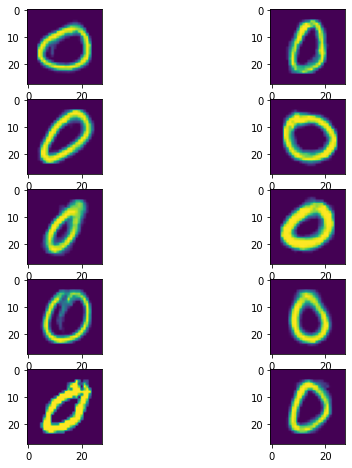

In [18]:
fig, axes = plt.subplots(5,2, figsize=(8, 8))
for i,ax in enumerate(axes.flat):
    ax.imshow(kmeans_prototypes[i].reshape(28, 28))
print()